In [1]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from dwave.system import DWaveSampler, FixedEmbeddingComposite
import dimod
import dwave_networkx as dnx
from minorminer import find_embedding
import dwave.inspector

In [2]:
# select quadratic program to solve
qp = QuadraticProgram()
qp.read_from_lp_file("example.lp")
qubo = QuadraticProgramToQubo().convert(qp)
bqm_binary = dimod.as_bqm(qubo.objective.linear.to_array(), qubo.objective.quadratic.to_array(), dimod.BINARY)
print(qp)
print(bqm_binary)
bqm_ising = bqm_binary.to_ising()
print("Ising Model form coefficients:")
print(bqm_ising)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: example_qp

Minimize
 obj: - x_0 - x_2 + [ - 2 x_0^2 + 2 x_0*x_2 - 4 x_2*x_1 + 2 x_1^2 ]/2
Subject To
 A0_eq_b0: - x_2 + x_1 = 0

Bounds
 0 <= x_0 <= 1
 0 <= x_2 <= 1
 0 <= x_1 <= 1

Binaries
 x_0 x_2 x_1
End

AdjVectorBQM({0: -2.0, 1: 7.0, 2: 9.0}, {(0, 1): 1.0, (1, 2): -18.0}, 0.0, 'BINARY')
Ising Model form coefficients:
({0: -0.75, 1: -0.75, 2: 0.0}, {(0, 1): 0.25, (1, 2): -4.5}, 2.75)


## Show all possible outcomes with energies

In [3]:
sampler_exact = dimod.ExactSolver()
sampleset = sampler_exact.sample(bqm_binary)
print(sampleset)

   0  1  2 energy num_oc.
5  1  1  1   -3.0       1
1  1  0  0   -2.0       1
4  0  1  1   -2.0       1
0  0  0  0    0.0       1
2  1  1  0    6.0       1
3  0  1  0    7.0       1
6  1  0  1    7.0       1
7  0  0  1    9.0       1
['BINARY', 8 rows, 8 samples, 3 variables]


## Find embedding

In [4]:
G = bqm_binary.to_networkx_graph()
P_16 = dnx.pegasus_graph(16)
embedding = find_embedding(G, P_16, timeout=60, tries=50)
P_16_sub = P_16.subgraph(list(itertools.chain(*embedding.values())))

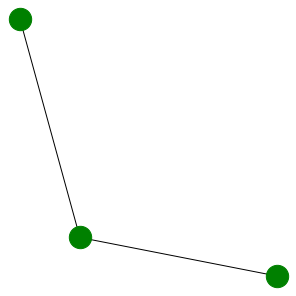

In [5]:
plt.figure(figsize=(4,4)) 
dnx.draw_pegasus(P_16_sub, node_size=500, node_color='g')

## Solve on advantage system

In [6]:
structured_sampler = dimod.StructureComposite(DWaveSampler(), P_16.nodes, P_16.edges)
sampler = FixedEmbeddingComposite(structured_sampler, embedding=embedding)
res = sampler.sample(bqm_binary, label="example_qubo_3", num_reads=100)
res.to_pandas_dataframe()

,0,1,2,chain_break_fraction,energy,num_occurrences
0,1,1,1,0.0,-3.0,33
1,0,1,1,0.0,-2.0,11
2,1,0,0,0.0,-2.0,56


In [7]:
dwave.inspector.show(res)

'http://127.0.0.1:18000/?problemId=2c4142f3-46f2-4e1c-8339-eb2af8566ab4'